Multipole Decomposition
====================================
*01/2021: updated to pyGDM v1.1+*


**New module `multipole` in v1.1.2**

<span style="color: red;">**!!CAUTION!!**</span>  **: this is a beta-functionality. Please report possible problems and errors.**

Here we demonstrate the multipole decomposition of the fields and the extinction spectra of arbitrary shaped nanostructures. The implementation in pyGDM is following reference [1].

In this example we reproduce the case of a silicon nano-cube with side-length 160nm in vacuum, shown in figure 3a of reference [1]. The multipole code however is based on the *exact multipole decomposition* theory from [2].


[1] Evlyukhin, A. B., Reinhardt, C. and Chichkov, B. N. *Multipole light scattering by nonspherical nanoparticles in the discrete dipole approximation*. **Phys. Rev. B** 84, 235429 (2011)

[2] Alaee, R., Rockstuhl, C. and Fernandez-Corbaton, I. *An electromagnetic multipole expansion beyond the long-wavelength approximation*. **Optics Communications** 407, 17-21 (2018)


Simulation setup
--------------------

In [1]:
from __future__ import print_function, division

## --- load the modules
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import multipole

Config and run simulation
-------------------------------------

Si nanocube of 160 nm side-length in vacuum, plane wave illumination. 

We discretize with 10 nm to achieve a relatively fast inversion for this demonstration.

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 1000/1000 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


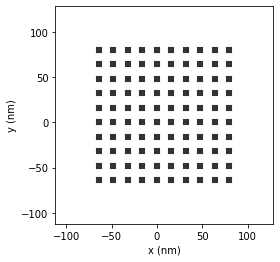

N dp=1000


/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.1 (/home/hans/.local/lib/python3.8/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()


timing for wl=450.00nm - setup: EE 1776.9ms, inv.: 597.4ms, repropa.: 684.4ms (1 field configs), tot: 3062.5ms
timing for wl=463.33nm - setup: EE 55.0ms, inv.: 87.6ms, repropa.: 1.1ms (1 field configs), tot: 146.5ms
timing for wl=476.67nm - setup: EE 67.6ms, inv.: 84.8ms, repropa.: 1.0ms (1 field configs), tot: 155.8ms
timing for wl=490.00nm - setup: EE 59.7ms, inv.: 86.8ms, repropa.: 1.1ms (1 field configs), tot: 150.3ms
timing for wl=503.33nm - setup: EE 57.7ms, inv.: 82.4ms, repropa.: 1.0ms (1 field configs), tot: 143.5ms
timing for wl=516.67nm - setup: EE 60.3ms, inv.: 90.6ms, repropa.: 1.1ms (1 field configs), tot: 154.4ms
timing for wl=530.00nm - setup: EE 64.4ms, inv.: 86.0ms, repropa.: 1.1ms (1 field configs), tot: 153.7ms
timing for wl=543.33nm - setup: EE 55.8ms, inv.: 86.5ms, repropa.: 1.1ms (1 field configs), tot: 145.9ms
timing for wl=556.67nm - setup: EE 57.7ms, inv.: 84.1ms, repropa.: 1.1ms (1 field configs), tot: 145.5ms
timing for wl=570.00nm - setup: EE 58.6ms, inv.: 

1

In [2]:
## --- simulation initialization ---
mesh = 'cube'
step = 16
geometry = structures.rect_wire(step, L=int(np.round(160/step)), 
                                      W=int(np.round(160/step)), 
                                      H=int(np.round(160/step)), mesh=mesh)
material = materials.silicon()
struct = structures.struct(step, geometry, material)

## incident field: lin. pol plane wave
field_generator = fields.planewave
wavelengths = np.linspace(450, 850, 31)
kwargs = dict(theta=0.0, kSign=-1)
efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)


## --- environment
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)

## --- create simulation instance
sim = core.simulation(struct, efield, dyads)

visu.structure(sim)
print("N dp={}".format(len(geometry)))

## --- run the main simulation ---
#sim.scatter(method='cupy')   # run on CUDA-GPU using "cupy" (to be installed via pip)
sim.scatter()


Extinction spectra
----------------------------------------------

Now we calculate the multipole decomposition of the extinction and compare it to the extinction spectrum obtained from the full discretization. Note that the blue-most resonance around 550nm is mainly electric-octupole (see PRB 84 235429, 2011), hence not contained in our decomposition into dipole and quadrupole moments.

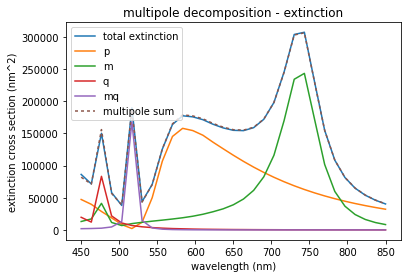

In [3]:
## -- spectra of extinction sections per multipole moment
wl, spec1 = tools.calculate_spectrum(sim, 0, linear.extinct)
ex, sc, ab = spec1.T
wl, spec2 = tools.calculate_spectrum(sim, 0, multipole.extinct)
ex_p, ex_m, ex_q, ex_mq = spec2.T

plt.plot(wl, ex, label='total extinction')
plt.plot(wl, ex_p, label='p')
plt.plot(wl, ex_m, label='m')
plt.plot(wl, ex_q, label='q')
plt.plot(wl, ex_mq, label='mq')
plt.plot(wl, ex_p + ex_m + ex_q + ex_mq, label='multipole sum', dashes=[2,2])

plt.legend()
plt.title("multipole decomposition - extinction")
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction cross section (nm^2)")
plt.show()

Scattering spectra
----------------------------------------------

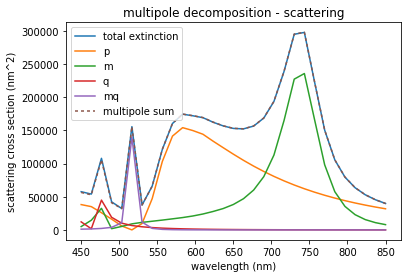

In [4]:
## -- spectra of scattering cross sections per multipole moment
wl, spec3 = tools.calculate_spectrum(sim, 0, multipole.scs)
sc_p, sc_m, sc_q, sc_mq = spec3.T

plt.plot(wl, sc, label='total extinction')
plt.plot(wl, sc_p, label='p')
plt.plot(wl, sc_m, label='m')
plt.plot(wl, sc_q, label='q')
plt.plot(wl, sc_mq, label='mq')
plt.plot(wl, sc_p + sc_m + sc_q + sc_mq, label='multipole sum', dashes=[2,2])

plt.legend()
plt.title("multipole decomposition - scattering")
plt.xlabel("wavelength (nm)")
plt.ylabel("scattering cross section (nm^2)")
plt.show()

plot the main contributing dipole moments
------------------------------------------------------

We set linear $X$ polarized, plane wave illumination, so we expect the electric dipole moment to be mainly oriented along $X$ and the magnetic dipole moment mainly along $Y$ (incidence along $Z$). This can be easily confirmed by the multipole decomposition:

*Note:* the dipole moments are determined by the arbitrarily chosen incident field amplitude (in pyGDM usually "1").

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:1265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectrum = np.array(spectrum)


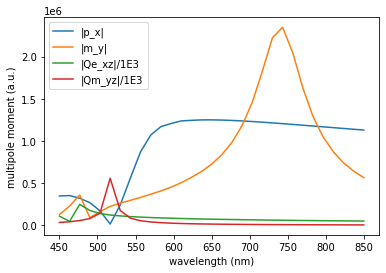

In [5]:
wl, spec_dpdecomp = tools.calculate_spectrum(sim, 0, multipole.multipole_decomposition_exact)
p = np.array([decomp[0] for decomp  in spec_dpdecomp])
m = np.array([decomp[1] for decomp  in spec_dpdecomp])
q = np.array([decomp[2] for decomp  in spec_dpdecomp])
mq = np.array([decomp[3] for decomp  in spec_dpdecomp])

plt.plot(wl, np.abs(p.T[0]), label='|p_x|')
plt.plot(wl, np.abs(m.T[1]), label='|m_y|')
plt.plot(wl, np.abs(q.T[0,2])/1E3, label='|Qe_xz|/1E3')
plt.plot(wl, np.abs(mq.T[1,2])/1E3, label='|Qm_yz|/1E3')
plt.legend()
plt.xlabel("wavelength (nm)")
plt.ylabel("multipole moment (a.u.)")
plt.show()